In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from scipy.ndimage import measurements
from skimage.morphology import label

from z3 import *
from IPython.display import Markdown, display


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/03/20190306_20_4_7.png" width="500" height="600">

In [2]:
# Set up the grids to be solved



grid4 =np.array([[0,0,0,7,0,0,0],
                 [5,0,0,0,0,6,0],
                 [0,0,2,0,0,0,0],
                 [5,0,0,0,0,0,7],
                 [0,0,0,0,7,0,0],
                 [0,7,0,0,0,0,3],
                 [0,0,0,6,0,0,0]])

top_looks4 = [5,0,5,0,2,0,7]
bot_looks4 = [4,0,6,0,4,0,3]
left_looks4 = [5,0,0,0,4,0,0]
right_looks4 = [0,0,7,0,0,0,4]

grid3 =np.array([[0,0,4,0,0,0,0],
                 [0,4,0,0,0,0,0],
                 [4,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,7],
                 [0,0,0,0,0,5,0],
                 [0,0,0,0,7,0,0]])

top_looks3 = [0,0,0,6,3,7,0]
bot_looks3 = [0,3,6,7,0,0,0]
left_looks3 = [0,0,0,2,6,3,0]
right_looks3 = [0,4,3,5,0,0,0]

grid2 =np.array([[0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0]])

top_looks2 = [6,4,4,6,7,3,3]
bot_looks2 = [2,6,7,7,2,4,7]
left_looks2 = [4,6,5,7,5,2,7]
right_looks2 = [3,6,3,3,7,6,7]

grid1=np.array([[0,7,6,0,0,0,0],
                [0,0,0,6,6,0,0],
                [5,0,0,0,0,0,0],
                [0,6,0,0,0,4,0],
                [0,0,0,0,0,0,6],
                [0,0,4,7,0,0,0],
                [0,0,0,0,7,7,5]])

top_looks1 = [0,0,0,0,0,5,7]
bot_looks1 = [7,2,0,0,0,0,0]
left_looks1 = [0,3,0,0,5,0,1]
right_looks1 = [4,0,4,0,0,2,0]


# Use -1 for empty rather than zero to track completion of cells
grid1[grid1==0]=-1
grid2[grid2==0]=-1
grid3[grid3==0]=-1
grid4[grid4==0]=-1

In [8]:
def neighbours( i, j):
        l=[]
        if i-1 >= 0:
            l.append((i-1,j))
        if i+1 < 7:
            l.append((i+1,j))
        if j-1 >= 0:
            l.append((i,j-1))
        if j+1 < 7:
            l.append((i,j+1))
        return l
       
def solve(grid,top,bot,left,right):

    start = time.time()
    s = Solver()

    X = [[Int("X_%s%s" % (i+1,j+1)) for j in range(7) ] for i in range(7) ]

    # limit the values and place the fixed values
    s += [And(X[i][j]>=0,X[i][j] <=7) for j in range(7) for i in range(7) ]
    s += [X[i][j] == int(grid[i,j]) for j in range(7) for i in range(7) if grid[i,j] > 0]

    # Row/Col Sums
    s += [Sum([X[i][j] for i in range(7)]) == 20 for j in range(7)]
    s += [Sum([X[i][j] for j in range(7)]) == 20 for i in range(7)]

    s += [PbEq([(X[i][j] ==0,1) for i in range(7)],3) for j in range(7)]
    s += [PbEq([(X[i][j] ==0,1) for j in range(7)],3) for i in range(7)]
  
    # only n instances of n  
    for n in range(1,8):
        s += PbEq([(X[i][j] == n,1) for j in range(7) for i in range(7)],n)

    #  row and col sums      
    s += [Sum([X[i][j] for j in range(7)]) == 20 for i in range(7)]
    s += [Sum([X[i][j] for i in range(7)]) == 20 for j in range(7)] 

    # no 2x2
    s += [Or(X[i][j] ==0,X[i+1][j] ==0,X[i][j+1] ==0,X[i+1][j+1] ==0) for j in range(6) for i in range(6)]

    s += [Implies(X[i][j] !=0,Or([X[k][l] !=0 for (k,l) in neighbours(i,j)])) for j in range(7) for i in range(7) ] 

    # looks
    for i in range(7):
        if left[i] !=0:
            s+= If(X[i][0] == 0,If(X[i][1] == 0,If(X[i][2] == 0,X[i][3] == int(left[i]),X[i][2] == int(left[i])),
                                   X[i][1] == int(left[i])),X[i][0] == int(left[i]))
            
        if right[i] !=0:
            s+= If(X[i][6] == 0,If(X[i][5] == 0,If(X[i][4] == 0,X[i][3] == int(right[i]),X[i][4] == int(right[i])),
                                   X[i][5] == int(right[i])),X[i][6] == int(right[i]))
        if top[i] !=0:
            s+= If(X[0][i] == 0,If(X[1][i] == 0,If(X[2][i] == 0,X[3][i] == int(top[i]),X[2][i] == int(top[i])),
                                   X[1][i] == int(top[i])),X[0][i] == int(top[i]))

        if bot[i] !=0:
            s+= If(X[6][i] == 0,If(X[5][i] == 0,If(X[4][i] == 0,X[3][i] == int(bot[i]),X[4][i] == int(bot[i])),
                                   X[5][i] == int(bot[i])),X[6][i] == int(bot[i]))
        
    # coding up the connectivity is hard so just solve and test then exclude solutions that are not connected
    count = 0
    while True:   
        if s.check() == sat:
            count += 1
            m = s.model()
            x = np.array([[m.evaluate(X[i][j]).as_long() for j in range(7)] for i in range(7)])
            if np.max(label(x != 0,connectivity=1)) == 1 :
                print('{} solutions took {:0.4f} seconds'.format(count,time.time()-start))
                return x
            s += Or([X[i][j]!=int(x[i,j]) for j in range(6) for i in range(6)])
        else:
            print("failed to solve") 
            break

    
    

1 solutions took 0.1217 seconds
1 solutions took 0.1466 seconds
1 solutions took 0.1426 seconds
2 solutions took 0.2174 seconds


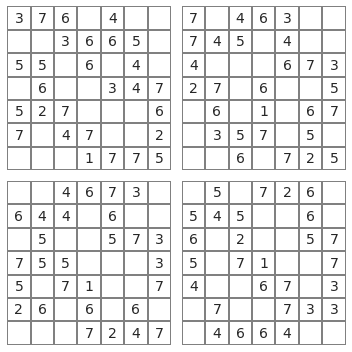

The solution is 8,150


In [9]:
solns= []

solns.append(solve(grid1,top_looks1,bot_looks1,left_looks1,right_looks1))
solns.append(solve(grid2,top_looks2,bot_looks2,left_looks2,right_looks2))
solns.append(solve(grid3,top_looks3,bot_looks3,left_looks3,right_looks3))
solns.append(solve(grid4,top_looks4,bot_looks4,left_looks4,right_looks4))

fig,ax = plt.subplots(2,2,figsize=(5,5)) 
for i,j in itertools.product(range(2),range(2)):
        y = np.array(solns[i+j*2]).astype('int').astype('str')
        y[y=="0"] =""
        sns.heatmap(np.zeros((7,7)),annot=y,cbar=False,cmap="Greys",fmt="",linewidths=1,center= 1,linecolor="grey",annot_kws={"size":14},ax=ax[i,j])
        ax[i,j].axis("off")
plt.tight_layout()
plt.show()

print("The solution is {:,.0f}".format(np.sum(np.sum(solns,0)**2)))

In [6]:
# Pull in the puzzle solution and grids from the solution page

url='https://www.janestreet.com/puzzles/solutions/march-2019-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:9]))

The completed grids are shown to the left, and below (in blue) is the “sum” grid. The sum of the squares of the values in this grid is 8150


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/04/20190329_20_4_7_solved.png" width="500" height="600">

In [7]:
np.sum(np.sum(solns,0)**2)

8150